In [ ]:
# This is a simplified implementation of the Next Best Action model from
#
# Theocharous, Georgios and Thomas, Philip S. and Ghavamzadeh, Mohammad
# Personalized Ad Recommendation Systems for Life-time Value Optimization with Guarantees
# Proceedings of the 24th International Conference on Artificial Intelligence, 2015
# https://www.ijcai.org/Proceedings/15/Papers/257.pdf
#
# See the walk-through article for more details:
# https://blog.griddynamics.com/building-a-next-best-action-model-using-reinforcement-learning/

### FQI Algorithm for reinforced learning - multidimentional NBA prediction

The idea of the FQI algorithm is to reduce the problem of learning the action-value function to a supervised learning problem. This is done with the iterative application of some supervised learning algorithm; we first train the model to predict the immediate reward based on state and action features, then train the second model to predict the return for two time steps ahead, and so on.

More specifically, let us assume that we have a number of trajectories collected under some baseline policy, and we cut these trajectories into a set of individual transitions, each of which is a tuple of the initial state, action, reward and new state:

T={(s,a,r,s′)}

### Setting up a testbed environment

We start building the Next Best Action model by setting up a simple testbed environment. First, let us assume a customer can do one of the following actions at any time step: take no action, visit a website or store without a purchase, or make a purchase. Let us also assume that a seller can provide a customer with one of three offers at any point of time or decide not to provide any offer. For the sake of illustration, we assume the semantic meaning of these offers are advertisement, small discount and large discount, respectively. For the sake of completeness, we also assume that customers have demographic and behavioral features. Without loss of generality, we use just one feature that can be either zero or one depending on the age group:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

events = [
    0, # no action
    1, # visit
    2  # purchase
]
offers = [
    1, # advertisement
    2, # small disocunt
    3  # large discount
]
demogr = [
    0, # low sensitivity
    1  # high sensitivity
]

n = 1000 # users
k = 100  # time intervals
m = 3    # offers
    
def multinomial_int(p):
    return np.where(np.random.multinomial(1, p) == 1)[0][0]

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

def find_offer_times(f):
    return np.nonzero(f)[0]

def offer_seq(f):
    return f[np.where(f > 0)]

Next, let's assume that we have some historical data at our disposal to learn the offer targeting policy. We create a customer profile generator that simulates three historical offer campaigns. For each customer, this generator iterates over 100 time steps, and issues three offers at randomized points of time. We initially use a random targeting policy, so that all offers have the same probability regardless of customer features. Customer behavior (i.e. event probabilities) changes over time as a function of previously received offers, and also depending upon demographic features:

In [23]:
def get_event_pr(d, f):
    f_ids = offer_seq(f) 
    f_ids = np.concatenate((f_ids, np.zeros(3 - len(f_ids))))
    
    if((f_ids[0] == 1 and f_ids[1] == 3) or 
       (f_ids[1] == 1 and f_ids[2] == 3) or 
       (f_ids[0] == 1 and f_ids[2] == 3)): 
            p_events = [0.70, 0.08, 0.22]     # higher probability of purchase
    else:
        p_events = [0.90, 0.08, 0.02]         # default
        
    if(np.random.binomial(1, 0.1) > 0):       # add some noise
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

def generate_profiles(n, k, m):
    
    p_offers = [1 / m] * m                                    # offer probabilities (behavioral policy)
    t_offers = np.linspace(0, k, m + 2).tolist()[1 : -1]      # offer campaing times
    t_offer_jit = 5                                           # offer time jitter, standard deviation in time units 
    
    P = np.zeros((n, k))                                      # matrix of profile events
    F = np.zeros((n, k))                                      # offer history
    D = np.zeros((n, 1))                                      # demographic features

    for u in range(0, n):
        D[u, 0] = np.random.binomial(1, 0.5)
    
        # determine m time points to issue offers for customer u
        offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)
        
        for t in range(0, k):                                   # simulate a trajectory for customer u
            if t in offer_times_u:
                F[u, t] = multinomial_int(p_offers) + 1         # issue an offer at time t according 
                                                                # to the behavioral policy 
   
            event = multinomial_int(get_event_pr(D[u], F[u]))   # simulate an event at time t
            P[u, t] = event
        
    return P, F, D

def visualize_profiles(P):
    fig, ax = plt.subplots(figsize=(10, 20))
    chart = ax.imshow(P)
    ax.set_aspect(0.05)
    plt.xlabel("time", fontdict={'size': 20, 'color': 'blue'})
    plt.ylabel("customer", fontdict={'size': 20, 'color': 'blue'})
    plt.colorbar(chart, fraction=0.025, pad=0.04, ax=ax)
    plt.show() 

This generator produces three matrices:

P— n×k     matrix of customer events
F — n×k    matrix of offers issued to customers
D — n×1    matrix of customer demographic features

The most important part of the simulator is a mapper of customer profiles to the vector of event probabilities. We define this mapper in such a way that the probability of a purchase is boosted if and only if the offer #1 (advertisement) is followed by the offer #3 (large discount):

In [12]:
def get_event_pr(d, f):
    f_ids = offer_seq(f)     # sequence of offer IDs received by the customer
    f_ids = np.concatenate((offer_seq(f), np.zeros(3 - len(f_ids))))
    
    if((f_ids[0] == 1 and f_ids[1] == 3) or 
       (f_ids[1] == 1 and f_ids[2] == 3) or 
       (f_ids[0] == 1 and f_ids[2] == 3)): 
            p_events = [0.70, 0.08, 0.22]     # higher probability of purchase
    else:
        p_events = [0.90, 0.08, 0.02]         # default behavior
        
    if(np.random.binomial(1, 0.1) > 0):       # add some noise
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

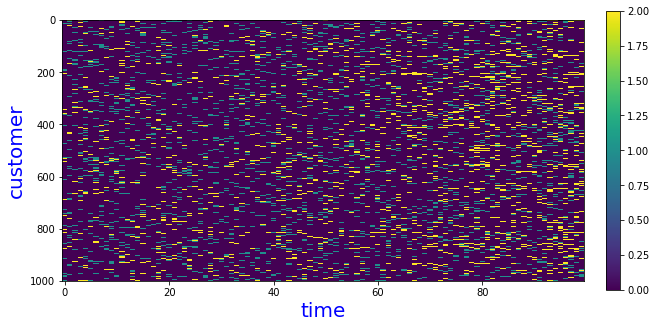

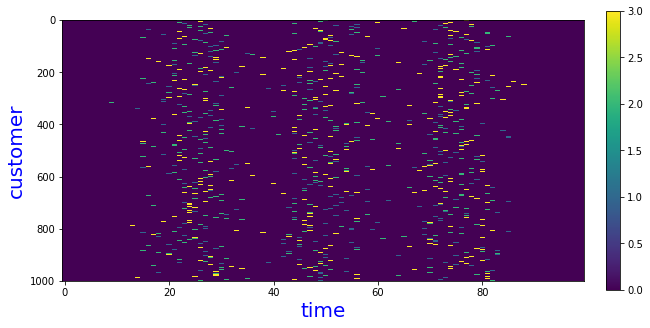

In [24]:
P, F, D = generate_profiles(n, k, m)          # training set
Pt, Ft, Dt = generate_profiles(n, k, m)       # test set

visualize_profiles(P)
visualize_profiles(F)

We can see in the top chart that the frequency of purchases increases over time (the density of the yellow dashes increases from left to right) because some customers get the right sequence of offers that triggers an increase in the purchase probability.

### Estimating the action-value function

Our next step is to learn the offer targeting policy using the FQI algorithm we introduced earlier. FQI works with individual transitions, so we need to cut the trajectories we previously generated into pieces as follows:

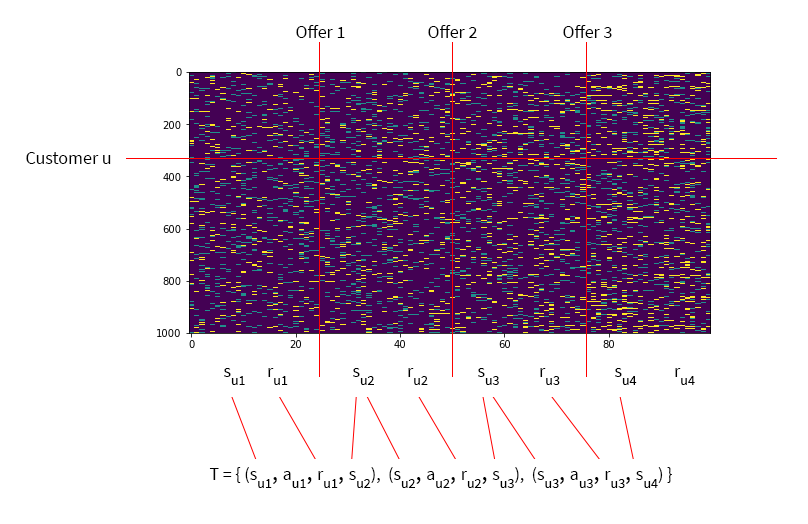

This way, each customer trajectory produces several transition tuples, and all tuples are merged into one training set. We choose to use the number of purchases in each transition as the reward metric, and represent each state as a vector of the following features: a demographic feature, the total number of visits from the beginning of the trajectory and time steps at which offers of each type were issued:

In [14]:
# p, f, d - rows of matrices P, F, and D that correspond to a given customer
# t_start, t_end - time interval 
def state_features(p, f, d, t_start, t_end):
    p_frame = p[0 : t_end]
    f_frame = f[0 : t_end]
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # visits
        index(f_frame, 1, k),  # first time offer #1 was issued
        index(f_frame, 2, k),  # first time offer #2 was issued
        index(f_frame, 3, k)   # first time offer #3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start : t_end], 2)   # number of purchases in the time frame

In [15]:
def prepare_trajectories(P, F, D):
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 
                
            T_u.append([state, action, reward, state_new])
            
        T.append(T_u) 
        
    return np.array(T)

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))

In [17]:
T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)

Once the data is ready, we can apply the FQI algorithm to learn the action-value function. We use the random forest algorithm from scikit-learn as a subroutine for  Q function estimation:

In [36]:
def Q_0(sa):
    return [1]

Q = Q_0
iterations = 6
for i in range(iterations):                 # FQI iterations
    X = []
    Y = []
    for sample in T.reshape((n * (m + 1), m + 1)):
        x = np.append(sample[0], sample[1]) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, sample[3], offers)
        y = sample[2] + v_best              # reward + value
    
        X.append(x)
        Y.append(y)
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict



ValueError: cannot reshape array of size 1000 into shape (4000,4)

In [38]:
# find the optimal action under a greedy policy and corresponding state value
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

Next, we can use the action-value function to make Next Best Action recommendations for the test set. It is insightful to visualize these recommended actions and corresponding action-value function estimates:

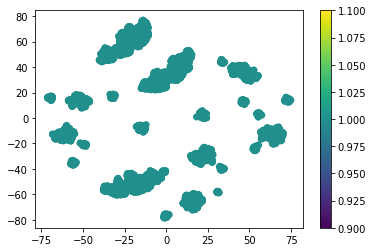

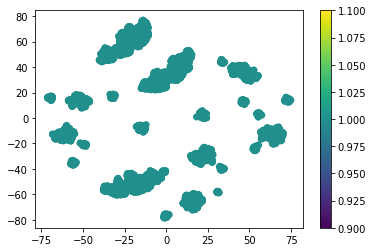

In [39]:
# use the test set to evaluate the policy
states = Tt[:, :, 0].flatten().tolist()

values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best)

s_tsne = TSNE().fit_transform(states)

# value function for each state
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c = values)
plt.colorbar()
plt.show()

# recommended next best actions for each state
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], c = best_actions)
plt.colorbar()
plt.show()

### Policy Evaluation

FQI provides a way to learn the Q function and derive some policy (e.g. epsilon-greedy) from it. 
If we change the policy, we need to evaluate its performance. It can be done using historical trajectories.

In [40]:
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_return = 0
        for transition in trajectory:            
            state, action, reward  = transition[0 : 3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_return += reward
            
        returns.append(trajectory_return * importance_weight)
        
    return np.mean(returns)

We use this evaluation procedure to quantify how the expected performance of an epsilon-greedy policy depends on the 
ϵ parameter:

In [41]:
def make_epsilon_greedy_policy(Q, eps):
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        else:
            return eps / (m - 1)
        
    return egreedy_policy


# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        for transition in trajectory:            
            state, action, reward  = transition[0:3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)   

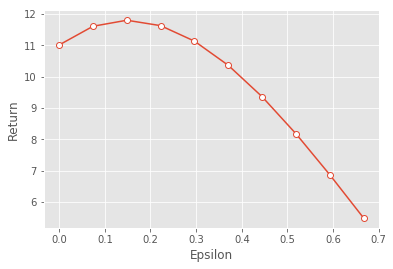

In [44]:
policy_values = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_values.append( evaluate_policy_return(T, behavioral_policy, policy) )

plt.style.use('ggplot')
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_values, '-o', mfc='w')
plt.show()

### Conclusion

Reinforcement learning provides a convenient framework for building Next Best Action models that generally need to combine predictive analytics, combinatorial optimization and active exploration of a dynamic environment. The ability to combine these elements in different ways is one of key advantages of the reinforcement learning framework. For instance, a basic offering optimization problem that requires only experimentation can be solved using multi-armed bandit algorithms. Then, the information about customers and offerings can be incorporated using contextual bandits, and then more strategic decisions can be made using generic reinforcement learning algorithms in a way described in this article. Finally, even more complex models can be created using deep reinforcement learning methods such as DQN. [2:2] [5]

The second advantage of the reinforcement learning approach is the flexibility of modeling. Similar to Monte Carlo simulations, it allows the incorporation of additional requirements, such as budgetary constraints, operational costs and business restrictions, by redefining reward functions or action sets. This provides more flexibility as compared to the manual casting of the optimization problem to some standard form, like linear or integer programming.

The same approach can be applied in many other areas of enterprise operations, including marketing, pricing, and logistics. For example, we discussed how multi-armed bandits can be used for dynamic price optimization in a previous blog post, and we can take this approach further using the MDP framework.

The complete implementation of the testbed environment described in this article is available on github. We used just plain python and scikit-learn to implement our toy model, but it is highly advisable to use reinforcement learning frameworks like OpenAI Gym for real production implementations to reliably handle all aspects and edge cases of modeling and optimization.